# Compressed Sensing with Denoising Autoencoders

## Dataset

Used dataset is the Caltech Birds 2011 datasest, a subset of ImageNet.

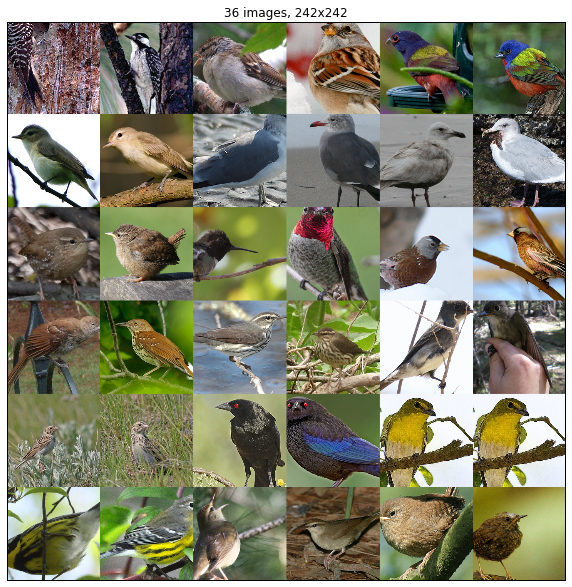

In [3]:
from numpy import *
import numpy.random as rnd
from pylab import *

import h5py, os, sys
from ilu_deepml import tools

%matplotlib inline

def _imshow(img, *args, **kwargs):
    imshow(img, *args, **kwargs)
    xticks([])
    yticks([])
    grid("off")

def load_images(nb_birds = 18, nb_samples_per_bird = 2, path="../data/birds/CUB_200_2011/images/"):
    assert(os.path.exists(path))

    files = os.listdir(path)
    files = rnd.choice(files, size=(nb_birds))

    selected_files = []
    for bird_path in (os.path.join(path, file) for file in files):
        subpath = os.listdir(bird_path)
        subpath = [os.path.join(bird_path, p) for p in rnd.choice(subpath, size=min(nb_samples_per_bird, len(subpath)))]
        selected_files += subpath

    psize = inf
    imgs = []
    for path in selected_files:
        img = imread(path)
        if img.ndim < 3:
            continue
        imgs.append(img)
        psize = min(psize, img.shape[0], img.shape[1], 256)
    X = zeros((len(imgs), 3, psize, psize))
    i = 0
    for img in imgs:
        w_i, h_i = img.shape[0:2]
        ov_w, ov_h = (w_i - psize) // 2, (h_i - psize) // 2
        try:
            X[i, :, :, :] = img[ov_w:ov_w+psize, ov_h:ov_h+psize, :].transpose((2, 0, 1))
        except:
            print(X.shape)
            print(img.shape)
            print(ov_w, ov_h, psize, i)
            raise
        i += 1
    return X

X = load_images()  

figure(figsize=(10,10))
_imshow(tools.panelize_images(X/255.))
title("%d images, %dx%d" % (X.shape[0],X.shape[2],X.shape[3]))
show()

# First Experiment: RGB AE with VGG weights

The used model is a VGGnet based Autoencoder.
Since the model was not originally designed as an autoencoder, normalizing layers have to be included in the network.

## Model Structure

The model uses only the first block of the VGG network. This limits the complexity by which the autoencoder can compress the data severely.
After two $3 \times 3$ blocks, a pooling layer reduces the feature map size by a factor of 4, yielding $\frac{M}{N} = 0.25$ for this model.
An unpooling layer followed by a deconvolution reverses the encoding operation.

## Hyperparams

Training hyperparams are:
    - learning rate of 0.1
    - momentum of 0.9

In [4]:
import sys, os, logging, time
from asyncio.tasks import sleep

import theano
import theano.tensor as T
from sklearn.cross_validation import StratifiedKFold
import h5py

from ilu_deepml.datasets import get_iluminate
from ilu_deepml.tools import logger_setup, panelize_images
from ilu_deepml.image_pre import get_datagen
import lasagne
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer, DropoutLayer,\
    InverseLayer, BiasLayer, BatchNormLayer, GaussianNoiseLayer, ScaleLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.nonlinearities import softmax, rectify, linear, sigmoid
from lasagne.layers import get_all_params, set_all_param_values, get_all_param_values, get_all_layers

from collections import OrderedDict

def build_model(input_var, initialNet=""):
    net = OrderedDict()
    initialNet=os.path.expanduser("~/tmp/experiments/modelzoo/vgg16_first_layers.hdf5")
    last = net['input'] = InputLayer((None, 3, None, None), input_var=input_var)
    last = net['noise'] = GaussianNoiseLayer(last, sigma=20)
    
    with h5py.File(initialNet, 'r') as f:
        last = net["conv1_1"] = ConvLayer(last, 64, 3, pad=1, flip_filters=False, nonlinearity=linear,
                                          W=f['param_0'][...], b=f['param_1'][...])
        last = net["relu1_1"] = NonlinearityLayer(last, nonlinearity=rectify)
        last = net["conv1_2"] = ConvLayer(last, 64, 3, pad=1, flip_filters=False, nonlinearity=linear,
                                        W=f['param_2'][...], b=f['param_3'][...])
        last = net["relu1_2"] = NonlinearityLayer(last, nonlinearity=rectify)
        last = net["pool"] = PoolLayer(last, 2)
        
        last = net["middle/conv"] = ConvLayer(last, 3, 3, nonlinearity=linear, b=None)
        last = net["middle"] = BatchNormLayer(last, gamma=lasagne.init.Constant(1e-2))
        last = net["relu_middle"] = NonlinearityLayer(last, nonlinearity=rectify)
        
        last = net["middle/conv2"] = InverseLayer(last, net["middle/conv"])
        last = net["middle2"] = BatchNormLayer(last)
        last = net["relu_middle"] = NonlinearityLayer(last, nonlinearity=rectify)

        last = net["unpool"]    = InverseLayer(last, net["pool"])
        last = net["deconv1_2"] = InverseLayer(last, net["conv1_2"])
        last = net["deconv1_1"] = InverseLayer(last, net["conv1_1"])

        last = net["outp"] = BatchNormLayer(last)
        f.close()
    return net

input_var = T.tensor4("input")
net = build_model(input_var)
prediction = lasagne.layers.get_output(net["outp"], deterministic=True)
pred_fn = theano.function([input_var], prediction, allow_input_downcast=True)


input_var = T.tensor4("inputs")
target_var = T.tensor4("targets")

network = build_model(input_var)

lr = theano.shared(np.array(0.1, dtype="float32"))
lr.set_value(0.1)
momentum = 0.9

print("Done")

Done


Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5004)


## Input and Output distributions after initialization

Inputs and outputs are normalized using the ImageNet dataset mean values (B=104, G=117, R=124).
The network's middle batch norm layer was initialized with $\gamma=0.01$ to compensate the magnitude of the VGGnet's weights.

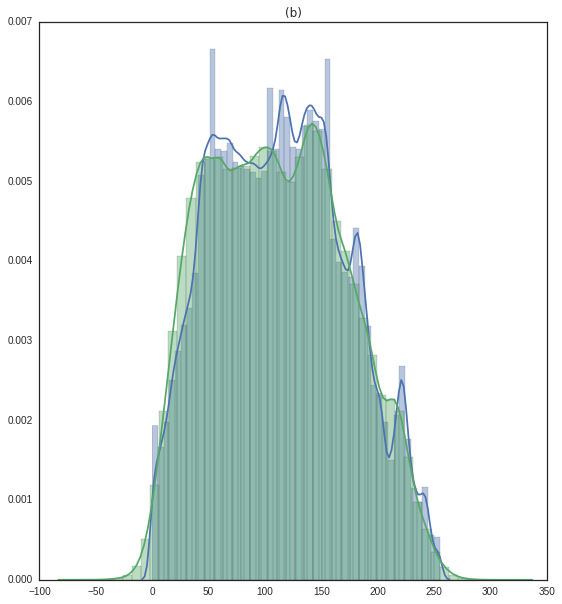

In [32]:
import seaborn as sns
sns.despine()
sns.set_style("white")

means = array([104, 117, 124])[newaxis, :, newaxis, newaxis]
norm = lambda x : (x[:,::-1,...] - means)
destand = lambda x : (x + means)[:, ::-1, ...]

featuremaps = apply_fn(norm(X))[:,::-1,:,:]

figure(figsize=(20,10))
subplot(1,2,1)
sns.distplot(X.flatten())
sns.distplot(featuremaps.flatten())
title("(b)")
show()

In [6]:
prediction = lasagne.layers.get_output(network["outp"])
loss = lasagne.objectives.squared_error(prediction, target_var)
loss = loss.flatten().mean()
params = []
for key in network.keys():#["middle", "middle2", "middle/conv","middle/conv2", "outp"]:#["middle/bn1", "outp"]: #for key in ["middle", "outp"]:
    params +=  network[key].get_params(trainable=True)
    print([p.get_value().shape for p in params])
print(params)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=lr, momentum=momentum)
train_fn = theano.function([input_var, target_var], [loss], updates=updates, allow_input_downcast=True)
prediction_test = lasagne.layers.get_output(network["outp"], deterministic=True)
apply_fn = theano.function([input_var], prediction, allow_input_downcast=True)

[]
[]
[(64, 3, 3, 3), (64,)]
[(64, 3, 3, 3), (64,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (3, 64, 3, 3)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (3, 64, 3, 3), (3,), (3,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (3, 64, 3, 3), (3,), (3,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (3, 64, 3, 3), (3,), (3,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (3, 64, 3, 3), (3,), (3,), (64,), (64,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (3, 64, 3, 3), (3,), (3,), (64,), (64,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (3, 64, 3, 3), (3,), (3,), (64,), (64,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (3, 64, 3, 3), (3,), (3,), (64,), (64,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (3, 64, 3, 3), (3,), (3,), (64,), (64,), (3,), (3,)]
[W, b, W, b, W, beta, gamma, beta, gamma, beta, gamma]


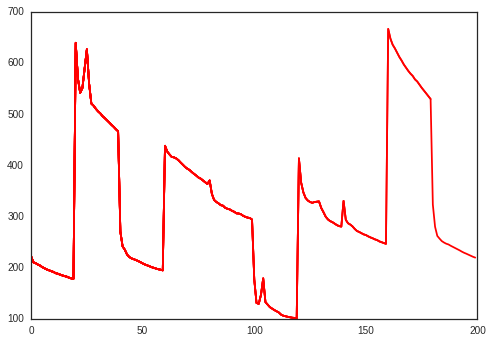

219.6304473876953


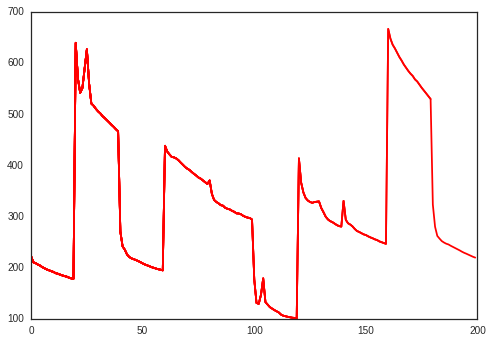

In [25]:
from IPython import display

losses = []
figure();
lr.set_value(0.001)

nb_epochs = 10
nb_iterations = 20

print(X.shape)

for i in range(nb_epochs):
    X = load_images(nb_birds=200)
    for j in range(nb_iterations):
        idc = slice(nb_iterations*10, 10*nb_iterations+10)
        err = train_fn(norm(X[idc,...]), X[idc, ::-1, ...])[0]
        losses.append(err)
        if math.isnan(err):
            print("nan")
            break
    plot(arange(len(losses)), losses, color="r")
    xlim([0, nb_epochs * nb_iterations])
    
    display.clear_output(wait=True)
    display.display(gcf())
    
    print(err)
    
    if math.isnan(err):
        print("nan")
        break

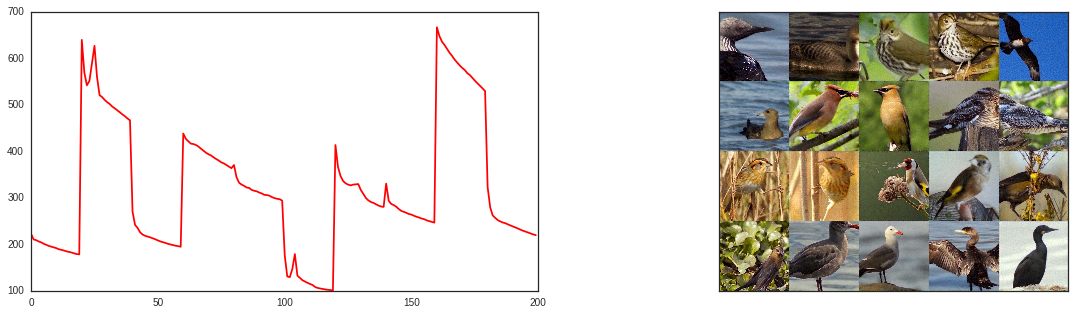

In [26]:
figure(figsize=(20,5))
subplot(1,2,1)
plot(arange(len(losses)), losses, color="r")
X = load_images(nb_birds=10)
images = apply_fn(norm(X))[:,::-1,:,:] / 255.

subplot(1,2,2)
_imshow(tools.panelize_images(np.clip(images, 0, 1)))
show()

# Color Reconstructions

Comparison of original images and their reconstruction using the proposed autoencoder model.
Residual images as well as the PSNR is computed as well.

Average PSNR:  25.9995917522  dB


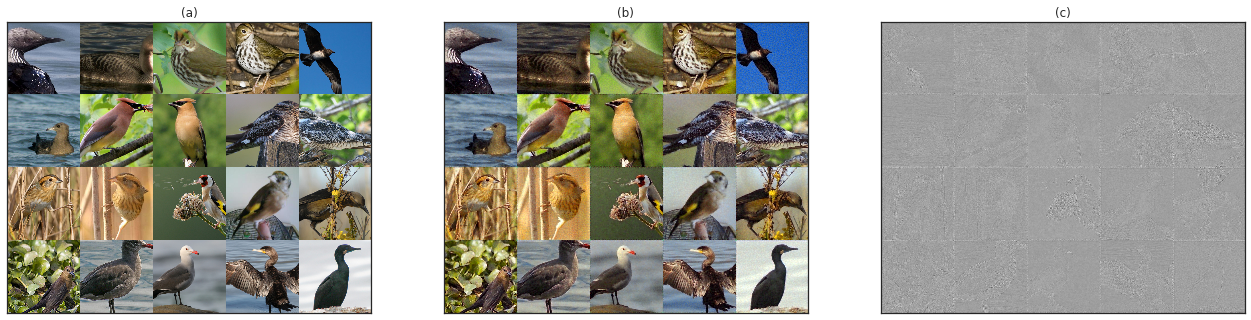

In [27]:
def psnr(orig, rec):
    return - 10 * log10(((orig - rec)**2).mean())

residual = tools.panelize_images(images - X/255.).sum(axis=-1)
sample = tools.panelize_images(X/255.)
reconstructed = tools.panelize_images(np.clip(images, 0, 1))

figure(figsize=(30,10))
subplot(1,4,1)
_imshow(sample)
title("(a)")
subplot(1,4,2)
_imshow(reconstructed)
title("(b)")
subplot(1,4,3)
_imshow(residual)
title("(c)")

print("Average PSNR: ", psnr(X/255., images), " dB")

show()

In [29]:
# Compressed Sensing Network

from lasagne.layers import TransposedConv2DLayer

def build_model(input_var, initialNet=""):
    net = OrderedDict()
    initialNet=os.path.expanduser("~/tmp/experiments/modelzoo/vgg16_first_layers.hdf5")
    last = net['input'] = InputLayer((None, 3, None, None), input_var=input_var)
    last = net['noise'] = GaussianNoiseLayer(last, sigma=20)
    
    with h5py.File(initialNet, 'r') as f:
        last = net["conv1_1"] = ConvLayer(last, 64, 3, pad=1, flip_filters=False, nonlinearity=linear,
                                          W=f['param_0'][...], b=f['param_1'][...])
        last = net["relu1_1"] = NonlinearityLayer(last, nonlinearity=rectify)
        last = net["conv1_2"] = ConvLayer(last, 64, 3, pad=1, flip_filters=False, nonlinearity=linear,
                                        W=f['param_2'][...], b=f['param_3'][...])
        last = net["relu1_2"] = NonlinearityLayer(last, nonlinearity=rectify)
        last = net["pool"] = PoolLayer(last, 2)
        
        last = net["middle"] = BatchNormLayer(last, gamma=lasagne.init.Constant(1e-2))
        last = net["middle/conv"] = ConvLayer(last, 64, 1, nonlinearity=linear, b=None)
        #last = net["middle/conv"] = ConvLayer(last, 64, 1, nonlinearity=linear, b=None)
        #last = net["middle/deconv"] = InverseLayer(last, net["middle/conv"])
        #last = net["middle/bn1"] = BatchNormLayer(last)
        #last = net["middle/relu1"] = NonlinearityLayer(last, nonlinearity=rectify)

        last = net["unpool"]    = InverseLayer(last, net["pool"])
        last = net["deconv1_2"] = InverseLayer(last, net["conv1_2"])
        last = net["deconv1_1"] = InverseLayer(last, net["conv1_1"])
        
        #last = net["outp/scale"] = ScaleLayer(last)
        #last = net["outp"] = BiasLayer(last)

        last = net["outp"] = BatchNormLayer(last)
        f.close()
    return net

input_var = T.tensor4("inputs")
target_var = T.tensor4("targets")
network = build_model(input_var)
lr = theano.shared(np.array(0.1, dtype="float32"))
lr.set_value(0.1)
momentum = 0.9
prediction = lasagne.layers.get_output(network["outp"])
loss = lasagne.objectives.squared_error(prediction, target_var)
loss = loss.flatten().mean()
params = []
for key in network.keys():
    params +=  network[key].get_params(trainable=True)
    print([p.get_value().shape for p in params])
print(params)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=lr, momentum=momentum)
train_fn = theano.function([input_var, target_var], [loss], updates=updates, allow_input_downcast=True)
prediction_test = lasagne.layers.get_output(network["outp"], deterministic=True)
apply_fn = theano.function([input_var], prediction, allow_input_downcast=True)

[]
[]
[(64, 3, 3, 3), (64,)]
[(64, 3, 3, 3), (64,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (64,), (64,)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (64,), (64,), (64, 64, 1, 1)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (64,), (64,), (64, 64, 1, 1)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (64,), (64,), (64, 64, 1, 1)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (64,), (64,), (64, 64, 1, 1)]
[(64, 3, 3, 3), (64,), (64, 64, 3, 3), (64,), (64,), (64,), (64, 64, 1, 1), (3,), (3,)]
[W, b, W, b, beta, gamma, W, beta, gamma]


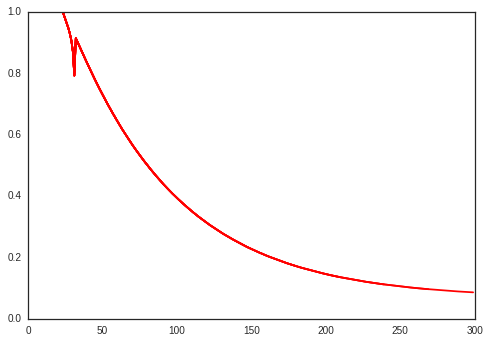

(120, 1, 224, 224)


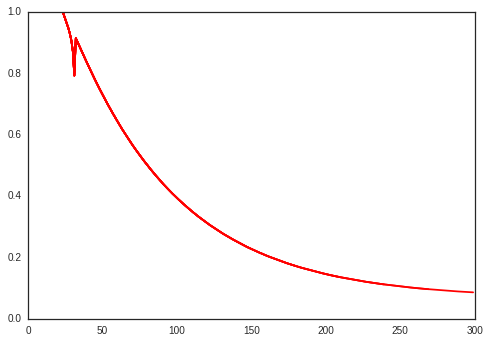

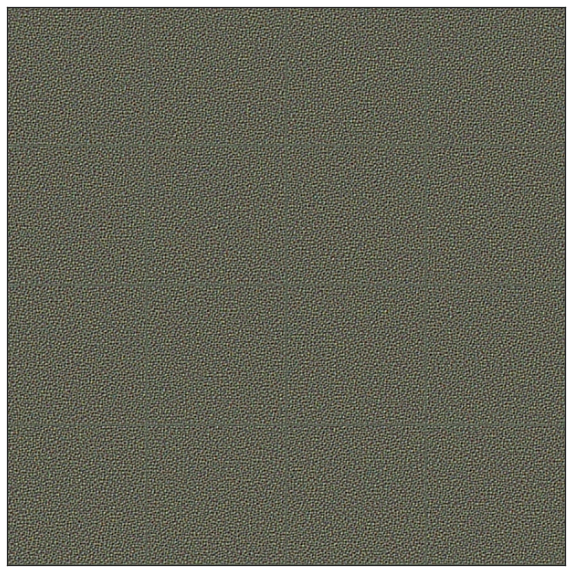

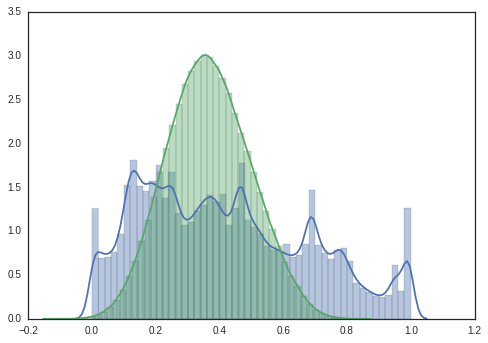

In [31]:
from IPython import display

losses = []
figure();
lr.set_value(0.001)

nb_epochs = 10
nb_iterations = 30

for i in range(nb_epochs):
    for j in range(nb_iterations):
        err = train_fn(inputs, inputs)[0]
        losses.append(err)
        if math.isnan(err):
            print("nan")
            break
    plot(arange(len(losses)), losses, color="r")
    xlim([0, nb_epochs * nb_iterations])
    ylim([0, 1])

    display.clear_output(wait=True)
    display.display(gcf())

    if math.isnan(err):
        print("nan")
        break

print(images.shape)
images = apply_fn(inputs)
figure(figsize=(10,10))
imshow(tools.panelize_images(np.clip(images, 0, 1)))
grid("off")
xticks([])
yticks([])
show()

sns.distplot(inputs.flatten())
sns.distplot(images.flatten())

show()

In [90]:
from lasagne.layers import PadLayer, Upscale2DLayer
from lasagne.nonlinearities import softmax, rectify, linear, sigmoid, tanh, ScaledTanH

def get_params(network, keys):
    params = []
    for key in keys:
        if not key in network:
            continue
        params +=  network[key].get_params(trainable=True)
    return params

def build_paper_model(input_var):
    net = OrderedDict()
    last = net['input'] = InputLayer((None, 1, 256, 256), input_var=input_var)
    last= net["noise"] = GaussianNoiseLayer(last, 0.05)
    last = net["conv1_1"] = ConvLayer(last, 128, 32, stride=(8, 8), nonlinearity=linear)
    last = net["relu"] = NonlinearityLayer(last, nonlinearity=ScaledTanH(scale_in=2./3, scale_out=1.7159))
    size_representation = array(lasagne.layers.get_output_shape(last)[1:]).prod()
    middle = lasagne.layers.get_output_shape(last)
    last = net["dropout"] = DropoutLayer(last, p=0.1)
    last = net["outp"] = InverseLayer(last, net["conv1_1"])
    #last = net["outp"] = BatchNormLayer(last)

    size_final = array(lasagne.layers.get_output_shape(last)[1:]).prod()
    print(size_representation, size_final, size_representation/size_final)
    return net

input_var = T.tensor4("inputs")
target_var = T.tensor4("targets")
network = build_paper_model(input_var)
lr = theano.shared(np.array(0.1, dtype="float32"))
momentum = 0.9
loss = lasagne.objectives.squared_error(lasagne.layers.get_output(network["outp"])[:,:,16:-16,16:-16],
                                        target_var[:,:,16:-16,16:-16]).flatten().mean()
params = get_params(network, ["conv1_1", "deconv1_1", "outp", "bn"])
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=lr, momentum=momentum)
train_fn = theano.function([input_var, target_var], [loss], updates=updates, allow_input_downcast=True)
prediction_test = lasagne.layers.get_output(network["outp"], deterministic=False)
apply_fn = theano.function([input_var], prediction_test, allow_input_downcast=False)

107648 65536 1.642578125


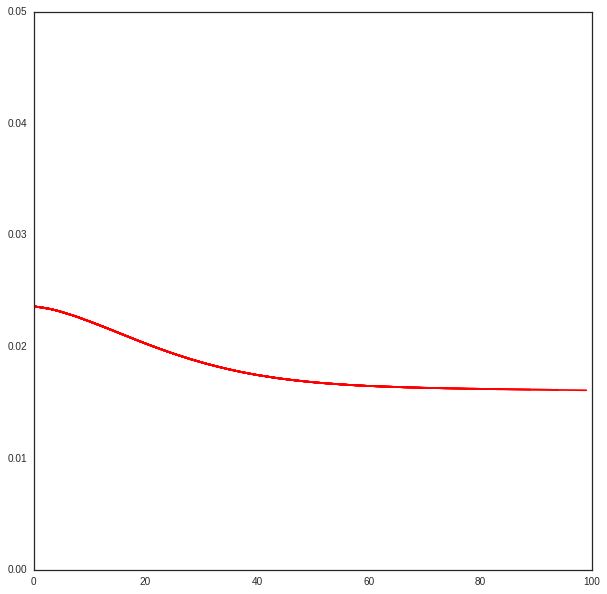

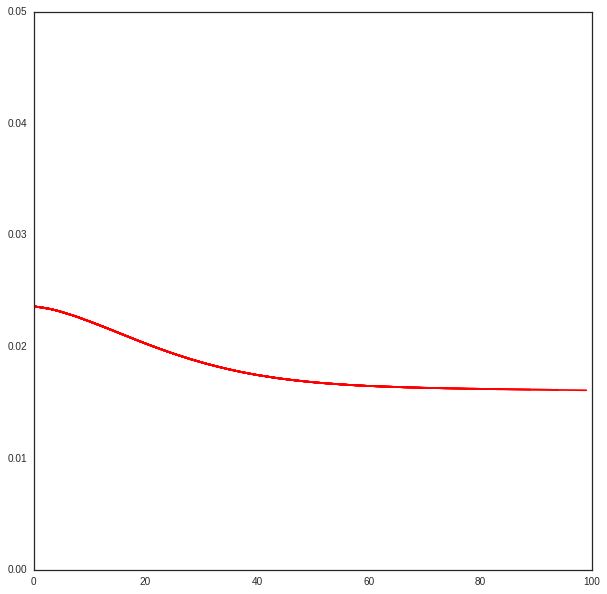

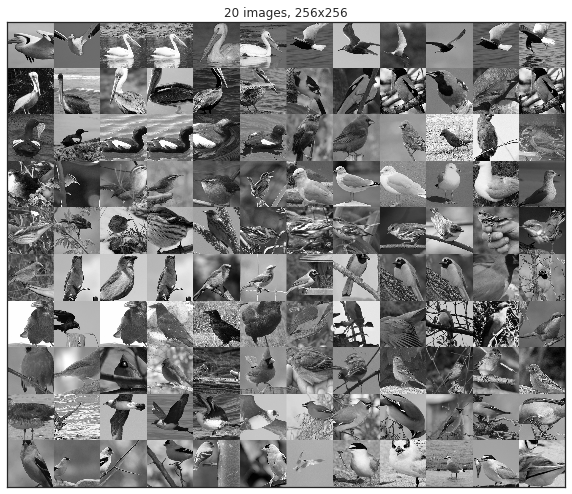

(120, 1, 149, 149)


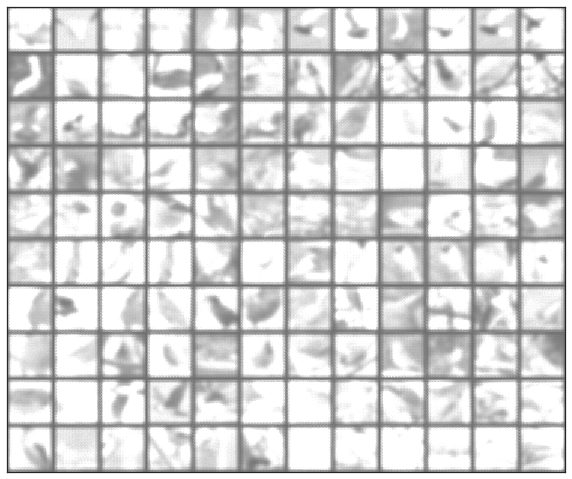

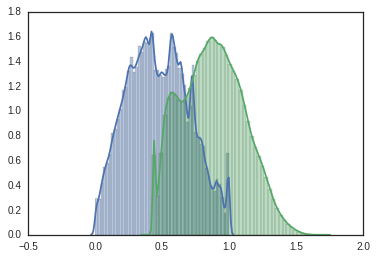

In [82]:
from scipy.signal import convolve2d

params = get_params(network, ["conv1_1", "deconv1_1", "outp"])
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=lr, momentum=momentum)
train_fn = theano.function([input_var, target_var], [loss], updates=updates, allow_input_downcast=True)

def train(nb_epochs = 10, nb_iterations = 30, train_fn=None, inputs=None, learning_rate=0.01):
    figure(figsize=(10,10));
    losses = []
    autocorr = []
    lr.set_value(learning_rate)
    for i in range(nb_epochs):
        for j in range(nb_iterations):
            err = train_fn(inputs - 0.44, inputs - 0.44)[0]
            losses.append(err)
            if math.isnan(err):
                print("nan")
                break
        
        plot(arange(len(losses)), losses, color="r")
        xlim([0, nb_epochs * nb_iterations])
        ylim([0, 0.05])
        
        display.clear_output(wait=True)
        display.display(gcf())
        
        if math.isnan(err):
            print("nan")
            break

inputs = load_images(nb_birds = 200, nb_samples_per_bird = 6).mean(axis=1)[:, newaxis, :, :] / 255.
train(nb_epochs = 20, nb_iterations = 5, train_fn=train_fn, inputs=inputs, learning_rate=0.001)

ValueError: GpuDnnConv images and kernel must have the same stack size

Apply node that caused the error: GpuDnnConv{algo='small', inplace=True}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode=(1, 1), subsample=(1, 1), conv_mode='cross', precision='float32'}.0, Constant{1.0}, Constant{0.0})
Toposort index: 106
Inputs types: [CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D), CudaNdarrayType(float32, 4D), <theano.gof.type.CDataType object at 0x7f187daa12e8>, Scalar(float32), Scalar(float32)]
Inputs shapes: [(120, 1, 140, 140), (64, 3, 3, 3), (120, 64, 140, 140), 'No shapes', (), ()]
Inputs strides: [(19600, 0, 140, 1), (27, 9, 3, 1), (1254400, 19600, 140, 1), 'No strides', (), ()]
Inputs values: ['not shown', 'not shown', 'not shown', <capsule object NULL at 0x7f187f3cc900>, 1.0, 0.0]
Inputs name: ('image', 'kernel', 'output', 'descriptor', 'alpha', 'beta')

Outputs clients: [[GpuElemwise{Composite{(i0 * ((i1 + i2) + Abs((i1 + i2))))}}[(0, 1)](CudaNdarrayConstant{[[[[ 0.5]]]]}, GpuDnnConv{algo='small', inplace=True}.0, GpuDimShuffle{x,0,x,x}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

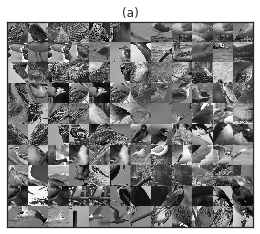

In [133]:
inputs = load_images(nb_birds = 20, nb_samples_per_bird = 6).mean(axis=1)[:, newaxis, :, :] / 255.

figure(figsize=(15,5))
subplot(1,3,1)
_imshow(tools.panelize_images(inputs))
title("(a)")

images = apply_fn(inputs)
subplot(1,3,2)
_imshow(tools.panelize_images(np.clip(images, 0, 1)))
title("(b)")

subplot(1,3,3)
sns.distplot(inputs.flatten(), label="input images")
sns.distplot(images.flatten(), label="reconstructions")
legend()
title("(c)")

show()

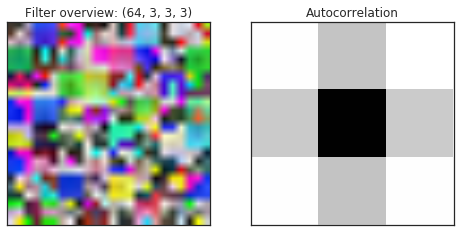

In [29]:
from scipy.signal import convolve2d

filters = network["conv1_1"].get_params()[0].get_value()

subplot(1,2,1)
_imshow(tools.panelize_images(filters))
title("Filter overview: " +str(filters.shape))

w_corr = zeros((filters.shape[2], filters.shape[3]))
for i in range(filters.shape[0]):
    w = filters[i, 0, :, :]
    w_corr += convolve2d(w, w[::-1,::-1], 'same')

subplot(1,2,2)
_imshow(w_corr, interpolation="none")
title("Autocorrelation")
show()

#print(w_corr[16, 16])

# Image compression using DCT

Demonstration of image compression by using $N$ DCT components with highest magnitude.
Used for comparison with autoencoder approaches.

0.0 1.0
-17.8728871943 0.00240805742045 144.279442402
49152 65536


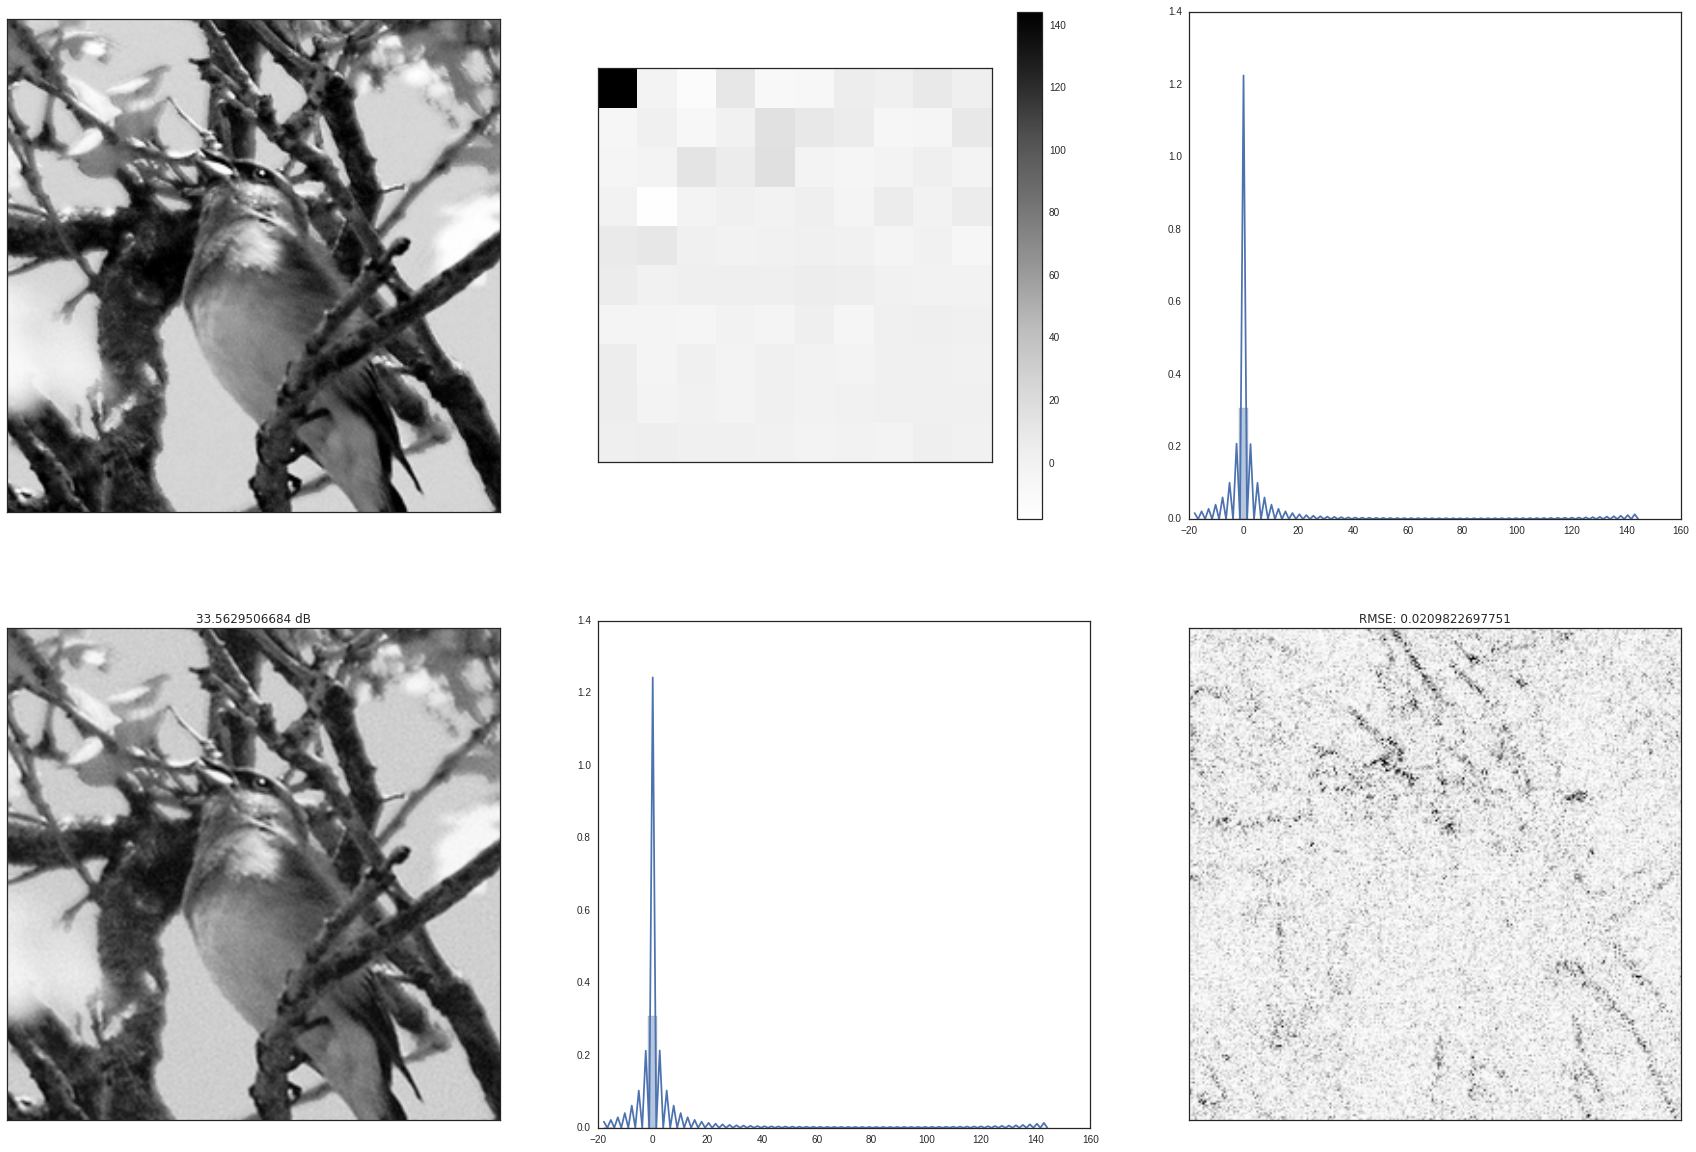

In [126]:
from scipy.fftpack import dct, idct

def get_2D_dct(img):
    """ Get 2D Cosine Transform of Image
    """
    return dct(dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return idct(idct(coefficients.T, norm='ortho').T, norm='ortho')

def psnr(orig, rec):
    return - 10 * log10(((orig - rec)**2).mean())

image = 1 - X[0,1,:] / 255.
print(image.min(), image.max())

# original image
figure(figsize=(30,20))
subplot(2,3,1)
_imshow(image)

# DCT coefficients
transf = get_2D_dct(image)
print(transf.min(), transf.mean(), transf.max())

subplot(2,3,2)
_imshow(transf[0:10, 0:10], interpolation="none")
colorbar()

# Histogram of DCT coeffcients
subplot(2,3,3)
sns.distplot(transf.flatten())

shape = transf.shape
N = int(shape[0] * shape[1])
M = int(N * 0.25)
print(N - M, N)

# Reconstruction
idc = argsort(abs(transf).flatten())
transf = transf.flatten()
transf[idc[:-M]] = 0
transf = transf.reshape(shape)
img_rec = get_2d_idct(transf)


subplot(2,3,4)
_imshow(img_rec)
title(str(psnr(image, img_rec)) + " dB")

subplot(2,3,5)
sns.distplot(transf.flatten())

residual = abs(image - img_rec)
subplot(2,3,6)
_imshow(residual, vmin=0, vmax=0.1)
title("RMSE: " + str((residual.flatten()**2).mean()**0.5))
show()